In [1]:
import anndata
import pandas as pd
import csv

import cellrank as  cr
import scanpy as sc
from scipy import sparse

import umap
import copy as cp
    
import scipy.sparse as sp

from harmony import harmonize
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import loompy
import celloracle as co


which: no R in (/home/msai/riemerpi001/.conda/envs/my_cell_env/bin:/cm/local/apps/environment-modules/4.5.3/bin:/home/msai/riemerpi001/.vscode-server/cli/servers/Stable-b58957e67ee1e712cebf466b995adf4c5307b2bd/server/bin/remote-cli:/cm/local/apps/environment-modules/4.5.3/bin:/home/msai/riemerpi001/.conda/envs/my_cell_env/bin:/apps/anaconda3/condabin:/cm/local/apps/gcc/11.2.0/bin:/home/msai/riemerpi001/.local/bin:/home/msai/riemerpi001/bin:/cm/local/apps/environment-modules/4.5.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/msai/riemerpi001/bin:/usr/bin:/usr/sbin:/cm/shared/apps/slurm/current/sbin:/tc2share/tc-scripts:/usr/share/centrifydc/bin:.:/sbin:/usr/sbin:/cm/local/apps/environment-modules/4.5.3/bin:/opt/dell/srvadmin/bin:/home/msai/riemerpi001/bin:/usr/bin:/usr/sbin:/cm/shared/apps/slurm/current/sbin:/tc2share/tc-scripts:/usr/share/centrifydc/bin:.)


In [2]:
# Load the LOOM file
loom_path = "/home/msai/riemerpi001/MscProjectDataAnalysis/data/GSE156793_S3_gene_count.loom"



## Readin

The file is too big to read at once (20gb ~>50 gb ram) so i will first read the first x rows. Then i will read the rest of the file in chunks and process it in chunks.

In [3]:
import loompy
import anndata


with loompy.connect(loom_path, 'r') as ds:
    # Slicing to read the first 100 samples (columns)
    # Transpose the matrix to fit AnnData structure: samples as rows, genes as columns
    data_matrix = ds[:, :100].T
    print(f"Transposed data matrix shape: {data_matrix.shape}")  # Should print (100, 63561)
    
    # Convert column attributes to pandas DataFrame for obs (observations)
    # Match this with the rows of the transposed data_matrix, which are samples
    obs = pd.DataFrame({attr: ds.col_attrs[attr][:100] for attr in ds.col_attrs.keys()})
    print(f"Observations shape: {obs.shape}")  # Should print (100, number_of_attributes)
    
    # Convert row attributes to pandas DataFrame for var (variables)
    # Match this with the columns of the transposed data_matrix, which are genes
    var = pd.DataFrame({attr: ds.row_attrs[attr] for attr in ds.row_attrs.keys()})
    print(f"Variables shape: {var.shape}")  # Should print (63561, number_of_attributes)

    # Creating an anndata object
    adata = anndata.AnnData(X=data_matrix, obs=obs, var=var)
    
# Now 'adata' contains the first 100 samples as an anndata object
print(adata)


Transposed data matrix shape: (100, 63561)
Observations shape: (100, 19)
Variables shape: (63561, 6)
AnnData object with n_obs × n_vars = 100 × 63561
    obs: 'All_reads', 'Assay', 'Batch', 'Development_day', 'Exon_reads', 'Experiment_batch', 'Fetus_id', 'Intron_reads', 'Main_cluster_name', 'Main_cluster_umap_1', 'Main_cluster_umap_2', 'Organ', 'Organ_cell_lineage', 'RT_group', 'Sex', 'Size_Factor', 'batch', 'obs_names', 'sample'
    var: 'exon_intron', 'gene_id', 'gene_short_name', 'gene_type', 'index', 'var_names'


In [4]:
adata

AnnData object with n_obs × n_vars = 100 × 63561
    obs: 'All_reads', 'Assay', 'Batch', 'Development_day', 'Exon_reads', 'Experiment_batch', 'Fetus_id', 'Intron_reads', 'Main_cluster_name', 'Main_cluster_umap_1', 'Main_cluster_umap_2', 'Organ', 'Organ_cell_lineage', 'RT_group', 'Sex', 'Size_Factor', 'batch', 'obs_names', 'sample'
    var: 'exon_intron', 'gene_id', 'gene_short_name', 'gene_type', 'index', 'var_names'

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)


... storing 'Assay' as categorical
... storing 'Batch' as categorical
... storing 'Experiment_batch' as categorical
... storing 'Fetus_id' as categorical
... storing 'Main_cluster_name' as categorical
... storing 'Organ' as categorical
... storing 'Organ_cell_lineage' as categorical
... storing 'RT_group' as categorical
... storing 'Sex' as categorical
... storing 'batch' as categorical
... storing 'exon_intron' as categorical
... storing 'gene_short_name' as categorical
... storing 'gene_type' as categorical


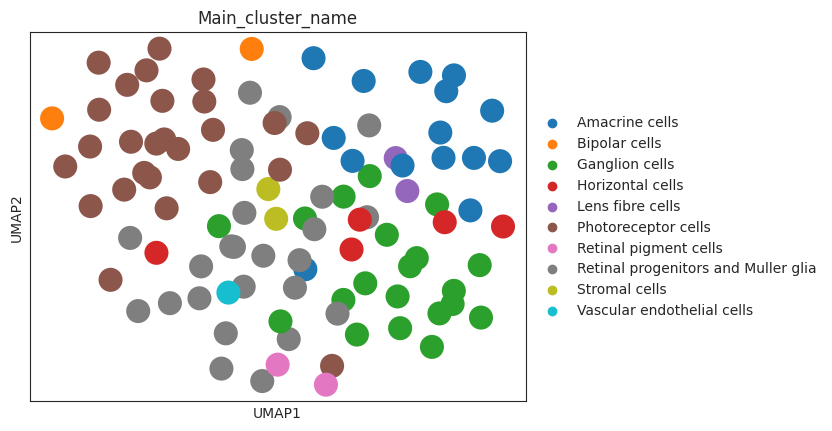

In [6]:
%matplotlib inline 
import scanpy as sc

sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color='Main_cluster_name')

In [7]:
adata.var["gene_id"]

0        ENSG00000223972.4
1        ENSG00000227232.4
2        ENSG00000243485.2
3        ENSG00000237613.2
4        ENSG00000268020.2
               ...        
63556    ENSG00000240779.1
63557    ENSG00000244656.1
63558    ENSG00000263760.1
63559    ENSG00000222670.2
63560    ENSG00000251180.2
Name: gene_id, Length: 63561, dtype: object

In [8]:
adata.var.head()  # Show variables/features (e.g., genes or peaks)
adata.obs.head()  # Show observations/cells


,All_reads,Assay,Batch,Development_day,Exon_reads,Experiment_batch,Fetus_id,Intron_reads,Main_cluster_name,Main_cluster_umap_1,Main_cluster_umap_2,Organ,Organ_cell_lineage,RT_group,Sex,Size_Factor,batch,obs_names,sample
0,372,Nuclei,10,117,70,exp2,H27552,243,Retinal progenitors and Muller glia,1.462221,1.554231,Eye,Eye-Retinal progenitors and Muller glia,Eye_H27552,M,NaN,0,expr2-human-577well.AAGGACGATTTCTTATCGA-0-0-0-...,expr2-human-577well.AAGGACGATTTCTTATCGA
1,458,Nuclei,10,117,84,exp2,H27552,299,Amacrine cells,0.445410,0.791980,Eye,Eye-Amacrine cells,Eye_H27552,M,NaN,0,expr2-human-577well.AACTAGTTGTGGTCCAGGAG-0-0-0...,expr2-human-577well.AACTAGTTGTGGTCCAGGAG
2,1005,Nuclei,10,117,137,exp2,H27552,700,Amacrine cells,0.579049,0.842920,Eye,Eye-Amacrine cells,Eye_H27552,M,NaN,0,expr2-human-577well.GCAACGTTTCTGATTAAGA-0-0-0-...,expr2-human-577well.GCAACGTTTCTGATTAAGA
3,469,Nuclei,4,129,82,exp2,H27458,324,Retinal progenitors and Muller glia,1.477098,1.602192,Eye,Eye-Retinal progenitors and Muller glia,Eye_H27458,F,NaN,0,expr2-human-577well.AAACCATAGTCCATTATCTA-0-0-0...,expr2-human-577well.AAACCATAGTCCATTATCTA
4,543,Nuclei,10,117,76,exp2,H27552,360,Retinal progenitors and Muller glia,1.691502,1.472312,Eye,Eye-Retinal progenitors and Muller glia,Eye_H27552,M,NaN,0,expr2-human-577well.TCGAGAAGTTAGGCAGATA-0-0-0-...,expr2-human-577well.TCGAGAAGTTAGGCAGATA


In [12]:
oracle = co.Oracle()

oracle.
# oracle.import_tf_network(network_model)

ValueError: Bin edges must be unique: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [ ]:
# Prepare the data for motif analysis
oracle.prepare_data_for_motif_analysis(reference_genome="mm10")  # Change the reference genome as per your data

# Scan for motifs
oracle.scan_motifs()

# Estimate transcription factor activities
oracle.estimate_activity_of_tfs()

In [ ]:
# first need to download HFA 
# cell oracle
# Using the HFA RNAseq and [[ATAC-seq]] to get a shortlist of the TFs active in each of the cells.